In [ ]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/aiken516/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
#from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

import time

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 385 (delta 22), reused 35 (delta 17), pack-reused 340
Receiving objects: 100% (385/385), 45.38 MiB | 27.73 MiB/s, done.
Resolving deltas: 100% (220/220), done.
renamed 'one-pixel-attack-keras/1_one_pixel_attack_cifar10.ipynb' -> './1_one_pixel_attack_cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
renamed 'one-pixel-attack-keras/data' -> './data'
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
renamed 'one-pixel-attack-keras/images' -> './images'
renamed 'one-pixel-attack-keras/LICENSE' -> './L

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

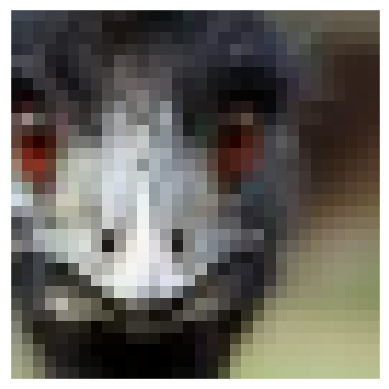

In [ ]:
image_id = 35 # Image index in the test set
helper.plot_image(x_test[image_id])

In [ ]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

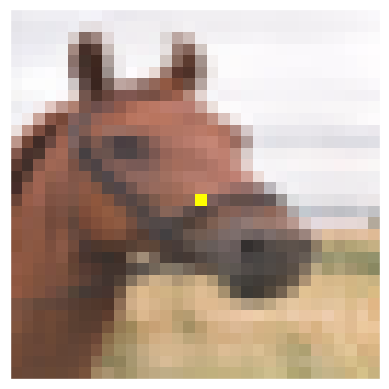

In [ ]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

In [ ]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet] #, resnet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lenet
Successfully loaded resnet


In [ ]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

1/1 [==============================] - 0s 69ms/step
0.70661694
00000000000000000000000000000000
[[4.9328293e-09 1.1879456e-06 7.0661694e-01 8.3695042e-05 2.3294629e-06
  2.9282969e-01 4.5851935e-04 2.0019311e-06 5.2639434e-06 3.5834640e-07]
 [2.8010146e-03 1.8197232e-05 3.6902354e-06 5.1215454e-07 1.3476672e-07
  6.0356193e-08 7.4653758e-07 6.9243868e-08 9.9717414e-01 1.3793547e-06]
 [5.0410310e-12 5.4933900e-13 1.6393385e-12 7.2156826e-16 6.6614114e-12
  2.0348840e-13 6.9652251e-14 1.0000000e+00 2.3134543e-14 1.3540914e-12]
 [2.6409686e-10 1.6825629e-08 9.9999177e-01 1.2117238e-07 1.2409730e-08
  7.7368304e-06 9.2792030e-10 3.4874770e-07 2.3245035e-09 1.5708268e-08]]
1/1 [==============================] - 0s 201ms/step
Confidence in true class bird is 0.00018887463
Prior confidence was 0.70661694


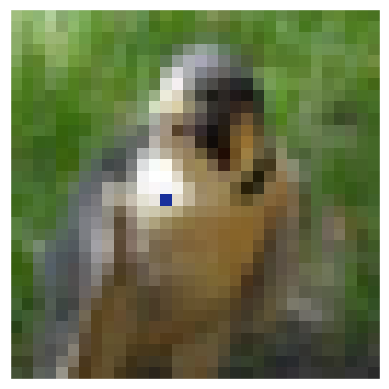

In [57]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]

xx = np.array([x_test[image_id], x_test[image_id+1], x_test[image_id+2], x_test[image_id+3]])

prior_confidence = model.predict_one(x_test[image_id])
print(prior_confidence[true_class])
print("00000000000000000000000000000000")

processed = resnet.color_process(xx)
result = resnet._model.predict(processed, batch_size=128,verbose=0)

print(result)
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence[true_class])
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

In [ ]:
def pixel_confidence(image_id):
    img_original = x_test[image_id].copy()
    #img_confidence = x_test[image_id].copy()
    #target_class = y_test[image_id, 0]
    target_class = 5
    print("target_class: {0}".format(target_class))

    helper.plot_image(img_original)

    prior_confidence =  model.predict_one(img_original)[target_class]
    print("prior_confidence: {0}".format(prior_confidence))

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img_original)

          after_confidence =  model.predict_one(perturbed_image)[target_class]
          print("after_confidence: {0}".format(after_confidence))

          diff_confidence = abs(after_confidence - prior_confidence)
          print("diff_confidence: {0}".format(diff_confidence))

          #img_confidence = perturb_image(np.array([x, y,  255 - diff_confidence * 255, 255 - diff_confidence * 255, 255 - diff_confidence * 255]), img_confidence)

          if diff_confidence > 0:
              for diff_index in range(len(diff_list)):
                  if diff_confidence >= diff_list[diff_index][2]:
                      diff_list.insert(diff_index, [x, y, diff_confidence])
                      if (len(diff_list) > 30):
                          diff_list.pop()
                      break

    for i in range(30):
         img_confidence = perturb_image(np.array([diff_list[i][0], diff_list[i][1],  (30- i) * 8.5, 0, 0]), img_confidence)
    print(diff_list)
    #helper.plot_image(img_confidence)

In [ ]:
model = lenet
pixel_confidence(384)

In [99]:
def pixel_confidence(image_id):
    img_original = x_test[image_id].copy()
    target_class = y_test[image_id, 0]
    print("target_class: {0}".format(target_class))

    helper.plot_image(img_original)

    prior_confidence =  model.predict_one(img_original)[target_class]
    print("prior_confidence: {0}".format(prior_confidence))

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    array = np.empty((0, 32, 32, 3))

    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img_original)

          array = np.append(array, np.array((perturbed_image)), axis=0)

    processed = model.color_process(array)
    result = model._model.predict(processed, batch_size=1024,verbose=0)

    for i in range(1024):
        after_confidence =  result[i][target_class]
        #print("after_confidence: {0}".format(after_confidence))

        diff_confidence = abs(after_confidence - prior_confidence)
        #print("diff_confidence: {0}".format(diff_confidence))

        if diff_confidence > 0:
            for diff_index in range(len(diff_list)):
                if diff_confidence >= diff_list[diff_index][1]:
                    diff_list.insert(diff_index, [i, diff_confidence])
                    if (len(diff_list) > 30):
                        diff_list.pop()
                    break

    print(diff_list)
    helper.plot_image(array[diff_list[0][0]])

target_class: 2


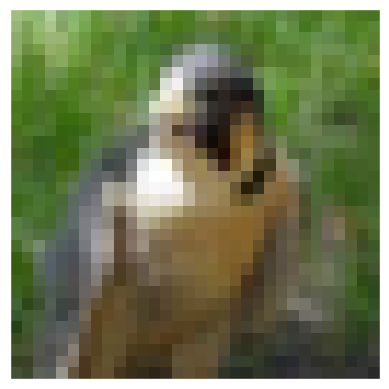

1/1 [==============================] - 0s 39ms/step
prior_confidence: 0.7066169381141663
[[525, 0.70655346], [559, 0.7065453], [524, 0.70645285], [494, 0.7063677], [526, 0.7063438], [589, 0.70631814], [492, 0.70625293], [463, 0.7062244], [431, 0.70613265], [462, 0.70610034], [461, 0.7060595], [557, 0.7059963], [588, 0.7058036], [556, 0.7057055], [493, 0.7055819], [460, 0.7054238], [398, 0.70541394], [558, 0.7018439], [430, 0.7009548], [397, 0.7000777], [878, 0.69890237], [365, 0.69644713], [527, 0.6958374], [908, 0.694128], [496, 0.69383264], [724, 0.69177485], [909, 0.6908316], [940, 0.688437], [910, 0.687951], [692, 0.6875734]]


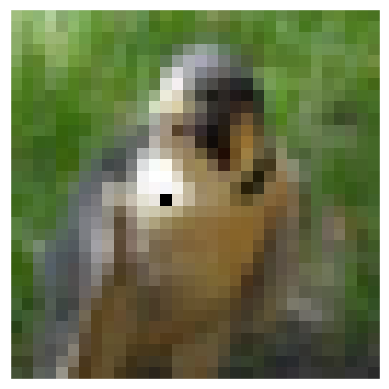

In [100]:
model = resnet
pixel_confidence(384)

In [ ]:
def bound(num):
    return int(max(0, min(31,num)))

def pixel_change(x, y):
    pixel_new = np.array([x, y,  0, 0, 0])

    for i in range(3):
        if img[x][y][i] >= 128:
          pixel_new[2 + i] = 0
        else:
          pixel_new[2 + i] = 255

    return pixel_new

def pixel_find(image_id):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    helper.plot_image(img)

    v_x = 0 #속도
    v_y = 0

    diff_list = [[0,0,0]]
    x = 0
    y = 0

    rate = 1
    momentum_rate = 0.99

    xy_list = [[7,7],[7,24],[24,7],[24,24]]

    ori_con = model.predict_one(img)[true_class]


    for xy in xy_list:
        x = xy[0]
        y = xy[1]


        for n in range(200):
            plus_x = ori_con - model.predict_one(perturb_image(pixel_change(bound(x+1), y), img))[true_class]
            minus_x = ori_con - model.predict_one(perturb_image(pixel_change(bound(x-1), y), img))[true_class]

            diff_x = plus_x - minus_x
            print("diff_x: {0}".format(diff_x))

            plus_y = ori_con - model.predict_one(perturb_image(pixel_change(x, bound(y+1)), img))[true_class]
            minus_y = ori_con - model.predict_one(perturb_image(pixel_change(x, bound(y-1)), img))[true_class]

            diff_y = plus_y - minus_y
            print("diff_x: {0}".format(diff_x))


            v_x = momentum_rate * v_x + diff_x * rate
            v_y = momentum_rate * v_y + diff_y * rate

            new_x = bound(x + v_x)
            new_y = bound(y + v_y)

            if (new_x == x and new_y == y):
                break

            x = new_x
            y = new_y

        print(" ==================== x, y: ({0}, {1})  ==================== ".format(x, y))


In [ ]:
model = resnet
image_id = 384
img = x_test[image_id].copy()
pixel_find(image_id)

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Axes의 타이틀을 설정
ax.set_title("Graph", size = 20)

# 축 라벨을 설정
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("confidence", size = 14)

In [ ]:
def one_color_graph(pixel, img_id, model, true_class, color):
    img = x_test[img_id]
    color_list = []
    confidence_list = []

    # 그래프의 타이틀을 설정
    plt.title("id:{0} model:{1} ({2}, {3}), ({4}, {5}, {6})".format(img_id, model.name, pixel[0], pixel[1], pixel[2], pixel[3], pixel[4]), size = 10)


    # color 인자로 변경할 값 찾기
    if color == 'r':
        color_num = 2
    elif color == 'g':
        color_num = 3
    elif color == 'b':
        color_num = 4

    for rgb in range(0, 255, step):
        pixel[color_num] = rgb

        imgs_perturbed = perturb_image(pixel, img)
        color_list.append(rgb)
        predictions = model.predict_one(imgs_perturbed)[true_class]
        confidence_list.append(predictions)

    plt.plot(color_list, confidence_list, color)
    plt.show()

def two_color_graph(pixel, img_id, model, true_class, color_1, color_2):
    img = x_test[img_id]
    color_list_x = []
    color_list_y = []
    confidence_list = []

    if color_1 == 'r':
        color_num_1 = 2
    elif color_1 == 'g':
        color_num_1 = 3
    elif color_1 == 'b':
        color_num_1 = 4

    if color_2 == 'r':
        color_num_2 = 2
    elif color_2 == 'g':
        color_num_2 = 3
    elif color_2 == 'b':
        color_num_2 = 4

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Axes의 타이틀을 설정
    ax.set_title("id:{0} model:{1} ({2}, {3}), ({4}, {5}, {6})".format(img_id, model.name, pixel[0], pixel[1], pixel[2], pixel[3], pixel[4]), size = 10)

    # 축 라벨을 설정
    ax.set_xlabel(color_1, size = 14)
    ax.set_ylabel(color_2, size = 14)
    ax.set_zlabel("confidence", size = 14)

    for rgb_x in range(0, 255, step):
      for rgb_y in range(0, 255, step):
          pixel[color_num_1] = rgb_x
          pixel[color_num_2] = rgb_y

          imgs_perturbed = perturb_image(pixel, img)
          color_list_x.append(rgb_x)
          color_list_y.append(rgb_y)
          predictions = model.predict_one(imgs_perturbed)[true_class]
          confidence_list.append(predictions)

    ax.scatter(color_list_x, color_list_y, confidence_list, 'r', alpha = 0.5)

def three_color_graph(pixel, img, model, true_class):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Axes의 타이틀을 설정
    ax.set_title("id:{0} model:{1} ({2}, {3})".format(img_id, model.name, pixel[0], pixel[1]), size = 10)

    # 축 라벨을 설정
    ax.set_xlabel("r", size = 14)
    ax.set_ylabel("g", size = 14)
    ax.set_zlabel("b", size = 14)

    for r in range(0, 255, step):
      pixel[2] = r
      for g in range(0, 255, step):
          pixel[3] = g
          for b in range(0, 255, step):
              pixel[4] = b

              imgs_perturbed = perturb_image(pixel, img)
              predictions = model.predict_one(imgs_perturbed)[true_class]
              ax.scatter(r, g, b, 'r', alpha = predictions)

In [ ]:
image_id = 4

pixel = np.array([16, 17,  255, 0, 0])

helper.plot_image(perturb_image(pixel, x_test[image_id]))

In [ ]:
image_id = 384
model = resnet

print(model.name)

resnet


In [ ]:
step = 8
image_id = 384
model = resnet

#['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(6, 10):
    true_class = i
    print(class_names[true_class])

    pixel = np.array([16, 13,  250, 247, 248])
    two_color_graph(pixel, image_id, model, true_class, 'g', 'b')

In [ ]:
#one_color_graph(pixel, image_id, model, true_class, 'r')
#one_color_graph(pixel, image_id, model, true_class, 'g')
#one_color_graph(pixel, image_id, model, true_class, 'b')
step = 8
model = resnet
pixel = np.array([17, 19,  161, 0, 0])
#two_color_graph(pixel, image_id, model, true_class, 'r', 'g')
#two_color_graph(pixel, image_id, model, true_class, 'r', 'b')
two_color_graph(pixel, image_id, model, true_class, 'g', 'b')

In [ ]:
step = 8
model = resnet
image_id = 384
true_class = y_test[image_id, 0]

for i in range(0, 70, 10):
    pixel = np.array([16, 12,  0, 0, i])
    two_color_graph(pixel, image_id, model, true_class, 'r', 'g')

In [ ]:
for i in range(70, 140, 10):
    pixel = np.array([16, 12,  0, 0, i])
    two_color_graph(pixel, image_id, model, true_class, 'r', 'g')

In [ ]:
for i in range(140, 210, 10):
    pixel = np.array([16, 12,  0, 0, i])
    two_color_graph(pixel, image_id, model, true_class, 'r', 'g')

In [ ]:
for i in range(210, 260, 10):
    pixel = np.array([16, 12,  0, 0, i])
    two_color_graph(pixel, image_id, model, true_class, 'r', 'g')

In [ ]:
def hill_climbing(image_id, pixel):
    img = x_test[image_id]
    stride = 8
    confidence = 1
    node_start = pixel
    selected_node = pixel

    for i in range(100):
        stuck = True
        for r in range(-1, 2, 1):
            for g in range(-1, 2, 1):
                for b in range(-1, 2, 1):
                    node = np.array([node_start[0], node_start[1], bound( node_start[2] + r * stride ), bound( node_start[3] + g * stride ), bound( node_start[4] + b * stride )])
                    imgs_perturbed = perturb_image(node, img)
                    predictions = model.predict_one(imgs_perturbed)[true_class]
                    if predictions < confidence:
                        selected_node = node
                        confidence = predictions
                        stuck = False
                        print(predictions)
        if stuck:
            break
        print("MOVE")
        node_start = selected_node

    imgs_perturbed = perturb_image(node_start, img)
    predictions = model.predict_one(imgs_perturbed)[true_class]
    print(predictions)
    print(node_start)

def bound(num):
    return max(0, min(255,num))


In [ ]:
pixel = np.array([17, 13,  128, 128, 128])
model = resnet
image_id = 384
true_class = y_test[image_id, 0]
hill_climbing(image_id, pixel)

In [ ]:
def gradient_descent(image_id, pixel):
    img = x_test[image_id]
    stride = 8
    confidence = 1

    x = pixel[0]
    y = pixel[1]
    r = pixel[2]
    g = pixel[3]
    b = pixel[4]

    for i in range(100):
        node = np.array([x, y, r, g, b])

        print("x:{0}, y:{1}, ({2} {3}, {4}), confidence: {5})".format(x, y, r, g, b, model.predict_one(perturb_image(node, img))[true_class]))
        node_plus = np.array([x, y, bound(r + 1), g, b])
        node_minus = np.array([x, y, bound(r - 1), g, b])

        diff_r = model.predict_one(perturb_image(node_plus, img))[true_class] - model.predict_one(perturb_image(node_minus, img))[true_class]
        #print("diff_r: {0}".format(diff_r))

        node_plus = np.array([x, y, r, bound(g + 1), b])
        node_minus = np.array([x, y, r, bound(g - 1), b])

        diff_g = model.predict_one(perturb_image(node_plus, img))[true_class] - model.predict_one(perturb_image(node_minus, img))[true_class]
        #print("diff_g: {0}".format(diff_g))

        node_plus = np.array([x, y, r, g, bound(b + 1)])
        node_minus = np.array([x, y, r, g, bound(b - 1)])

        diff_b = model.predict_one(perturb_image(node_plus, img))[true_class] - model.predict_one(perturb_image(node_minus, img))[true_class]
        #print("diff_b: {0}".format(diff_b))

        rate = 5000

        new_r = bound(r - diff_r * rate)
        new_g = bound(g - diff_g * rate)
        new_b = bound(b - diff_b * rate)

        if (new_r == r and new_g == g and new_b == b):
            break

        r = new_r
        g = new_g
        #b = new_b

def bound(num):
    return int(max(0, min(255,num)))

In [ ]:
pixel = np.array([16, 13,  250, 247, 248])
model = resnet
image_id = 384
true_class = y_test[image_id, 0]
gradient_descent(image_id, pixel)

In [ ]:
def gradient_descent_momentum(image_id, pixel):
    img = x_test[image_id]
    true_class = y_test[image_id, 0]

    x = pixel[0]
    y = pixel[1]
    r = pixel[2]
    g = pixel[3]
    b = pixel[4]

    rate = 5000
    momentum_rate = 0.99

    v_r = 0 #속도
    v_g = 0
    v_b = 0

    for i in range(100):
        node = np.array([x, y, r, g, b])
        ori_con = model.predict_one(perturb_image(node, img))[true_class]

        if (ori_con < 0.5):
            return True

        print("x:{0}, y:{1}, rgb:({2}, {3}, {4}), confidence: {5})".format(x, y, r, g, b, ori_con))
        node_plus = np.array([x, y, bound(r + 1), g, b])
        node_minus = np.array([x, y, bound(r - 1), g, b])

        diff_r = model.predict_one(perturb_image(node_plus, img))[true_class] - model.predict_one(perturb_image(node_minus, img))[true_class]
        print("diff_r: {0}".format(diff_r))

        node_plus = np.array([x, y, r, bound(g + 1), b])
        node_minus = np.array([x, y, r, bound(g - 1), b])

        diff_g = model.predict_one(perturb_image(node_plus, img))[true_class] - model.predict_one(perturb_image(node_minus, img))[true_class]
        print("diff_g: {0}".format(diff_g))

        node_plus = np.array([x, y, r, g, bound(b + 1)])
        node_minus = np.array([x, y, r, g, bound(b - 1)])

        diff_b = model.predict_one(perturb_image(node_plus, img))[true_class] - model.predict_one(perturb_image(node_minus, img))[true_class]
        print("diff_b: {0}".format(diff_b))

        v_r = momentum_rate * v_r - diff_r * rate
        v_g = momentum_rate * v_g - diff_g * rate
        v_b = momentum_rate * v_b - diff_b * rate

        new_r = bound(r + v_r)
        new_g = bound(g + v_g)
        new_b = bound(b + v_b)

        if (new_r == r and new_g == g and new_b == b):
            break

        r = new_r
        g = new_g
        b = new_b

    return False

def bound(num):
    return int(max(0, min(255,num)))

In [ ]:
def pixel_attackable(image_id):
    img_original = x_test[image_id].copy()
    img_map = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    helper.plot_image(img_original)

    point = [[0,0,0],[0,0,255],[0,255,0],[255,0,0],[0,255,255],[255,0,255],[255,255,0],[255,255,255]]

    for x in range(32):
        for y in range(32):
            succese = False
            for p in point:
                pixel = np.array([x, y, p[0], p[1], p[2]])
                con = model.predict_one(perturb_image(pixel, img_original))[true_class]
                if (con < 0.5):
                    succese = True
                    break

            if (succese):
                img_map = perturb_image(np.array([x, y,  255, 255, 255]), img_map)
                print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% x:{0}, y:{1}, SUCCESE:(TRUE) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%".format(x, y))
            else:
                img_map = perturb_image(np.array([x, y,  0, 0, 0]), img_map)
                print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% x:{0}, y:{1}, SUCCESE:(FALSE) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%".format(x, y))

    helper.plot_image(img_map)

In [ ]:
pixel = np.array([16, 13, 229, 224, 217])
model = resnet
image_id = 384
gradient_descent_momentum(image_id, pixel)

In [ ]:
model = resnet
image_id = 1470
pixel_attackable(image_id)

In [ ]:
def gradient_descent_momentum_target(image_id, pixel, target_class):
    img = x_test[image_id]

    x = pixel[0]
    y = pixel[1]
    r = pixel[2]
    g = pixel[3]
    b = pixel[4]

    rate = 1000
    momentum_rate = 0.99

    v_r = 0 #속도
    v_g = 0
    v_b = 0

    for i in range(1000):
        node = np.array([x, y, r, g, b])

        print("x:{0}, y:{1}, rgb:({2}, {3}, {4}), confidence: {5})".format(x, y, r, g, b, model.predict_one(perturb_image(node, img))[target_class]))
        node_plus = np.array([x, y, bound(r + 1), g, b])
        node_minus = np.array([x, y, bound(r - 1), g, b])

        diff_r = model.predict_one(perturb_image(node_plus, img))[target_class] - model.predict_one(perturb_image(node_minus, img))[target_class]
        #print("diff_r: {0}".format(diff_r))

        node_plus = np.array([x, y, r, bound(g + 1), b])
        node_minus = np.array([x, y, r, bound(g - 1), b])

        diff_g = model.predict_one(perturb_image(node_plus, img))[target_class] - model.predict_one(perturb_image(node_minus, img))[target_class]
        #print("diff_g: {0}".format(diff_g))

        node_plus = np.array([x, y, r, g, bound(b + 1)])
        node_minus = np.array([x, y, r, g, bound(b - 1)])

        diff_b = model.predict_one(perturb_image(node_plus, img))[target_class] - model.predict_one(perturb_image(node_minus, img))[target_class]
        #print("diff_b: {0}".format(diff_b))

        v_r = momentum_rate * v_r + diff_r * rate
        v_g = momentum_rate * v_g + diff_g * rate
        v_b = momentum_rate * v_b + diff_b * rate

        new_r = bound(r + v_r)
        new_g = bound(g + v_g)
        new_b = bound(b + v_b)

        if (new_r == r and new_g == g and new_b == b):
            break

        r = new_r
        g = new_g
        b = new_b

def bound(num):
    return int(max(0, min(255,num)))

In [ ]:
pixel = np.array([16, 13,  128, 128, 128])
model = resnet
image_id = 384
true_class = y_test[image_id, 0]
gradient_descent_momentum_target(image_id, pixel, 5)

1/1 [==============================] - 1s 1s/step
x:16, y:13, rgb:(128, 128, 128), confidence: 0.4521816372871399)
1/1 [==============================] - 0s 35ms/step
x:16, y:13, rgb:(113, 111, 130), confidence: 0.7951576113700867)
1/1 [==============================] - 0s 37ms/step
x:16, y:13, rgb:(82, 73, 135), confidence: 0.9944161176681519)
1/1 [==============================] - 0s 36ms/step
x:16, y:13, rgb:(50, 35, 140), confidence: 0.9996620416641235)
1/1 [==============================] - 0s 34ms/step
x:16, y:13, rgb:(19, 0, 145), confidence: 0.9999175071716309)
1/1 [==============================] - 0s 35ms/step
x:16, y:13, rgb:(0, 0, 150), confidence: 0.9999443292617798)
1/1 [==============================] - 0s 32ms/step
x:16, y:13, rgb:(0, 0, 155), confidence: 0.9999455213546753)
1/1 [==============================] - 0s 31ms/step
x:16, y:13, rgb:(0, 0, 160), confidence: 0.9999468326568604)
1/1 [==============================] - 0s 34ms/step
x:16, y:13, rgb:(0, 0, 165), conf